<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/TOI_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisities

In [72]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [43]:
toi = pd.read_csv('TOI_2025.09.26_07.08.49.csv', comment='#')
toi.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


## Feature Selection

In [44]:
features = ["pl_orbper", "pl_trandurh", "pl_trandep", "pl_rade", "pl_eqt", "pl_insol","st_teff", "st_logg", "st_rad", "st_tmag", "st_dist", "st_raderr1", "st_raderr2"]

Label Mapping

In [45]:
label_map = {
    "CP": 1,   # Confirmed Planet
    "KP": 1,   # Known Planet
    "PC": 0,   # Planet Candidate
    "APC": 0,  # Ambiguous Planet Candidate
    "FP": -1,  # False Positive
    "FA": -1   # False Alarm
}

toi["tfopwg_disp"] = toi["tfopwg_disp"].map(label_map)

## Filling empty cells

### Numerical Values

In [46]:
numerical_cols = ["pl_orbper","pl_trandurh","pl_trandep","pl_rade",
                  "pl_insol","pl_eqt","st_teff","st_logg","st_rad",
                  "st_tmag","st_dist", "st_raderr1", "st_raderr2"]

for col in numerical_cols:
    toi[col].fillna(toi[col].mean(), inplace=True)


/tmp/ipython-input-2967634529.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toi[col].fillna(toi[col].mean(), inplace=True)


### Strings

In [47]:
toi["tfopwg_disp"].fillna(toi["tfopwg_disp"].mode(), inplace=True)

/tmp/ipython-input-2156541520.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toi["tfopwg_disp"].fillna(toi["tfopwg_disp"].mode(), inplace=True)


Checking if NaN available

In [48]:
print(toi.isna().sum())

toi            0
tid            0
tfopwg_disp    0
rastr          0
ra             0
              ..
st_raderr1     0
st_raderr2     0
st_radlim      0
toi_created    0
rowupdate      0
Length: 65, dtype: int64


Defining data sets

In [49]:
X = toi[features]
y = toi["tfopwg_disp"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [52]:
classes = np.unique(y_train)

Calculating Class Weights

In [53]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [54]:
class_weights = dict(zip(classes, weights))

## Cat Boost Initiation

### Parameters


In [55]:
max_ite = 500
dep = 6
l_rate = 0.05

In [56]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [57]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0806250	test: 1.0815141	best: 1.0815141 (0)	total: 82.8ms	remaining: 41.3s
50:	learn: 0.8233387	test: 0.8481035	best: 0.8481035 (50)	total: 1.44s	remaining: 12.6s
100:	learn: 0.7526764	test: 0.7958415	best: 0.7958415 (100)	total: 2.1s	remaining: 8.29s
150:	learn: 0.7132965	test: 0.7709808	best: 0.7709808 (150)	total: 2.7s	remaining: 6.25s
200:	learn: 0.6809468	test: 0.7553719	best: 0.7553719 (200)	total: 3.28s	remaining: 4.88s
250:	learn: 0.6469268	test: 0.7430682	best: 0.7430682 (250)	total: 3.88s	remaining: 3.85s
300:	learn: 0.6199268	test: 0.7373377	best: 0.7373377 (300)	total: 4.48s	remaining: 2.96s
350:	learn: 0.5967166	test: 0.7334222	best: 0.7334222 (350)	total: 5.06s	remaining: 2.15s
400:	learn: 0.5746707	test: 0.7318763	best: 0.7315845 (397)	total: 5.67s	remaining: 1.4s
450:	learn: 0.5554931	test: 0.7316835	best: 0.7312681 (445)	total: 6.25s	remaining: 680ms
499:	learn: 0.5370810	test: 0.7306987	best: 0.7305564 (484)	total: 6.84s	remaining: 0us

bestTest = 0.730556

# Evaluation

In [58]:
y_pred = model.predict(X_test)

### Confusion Matrix

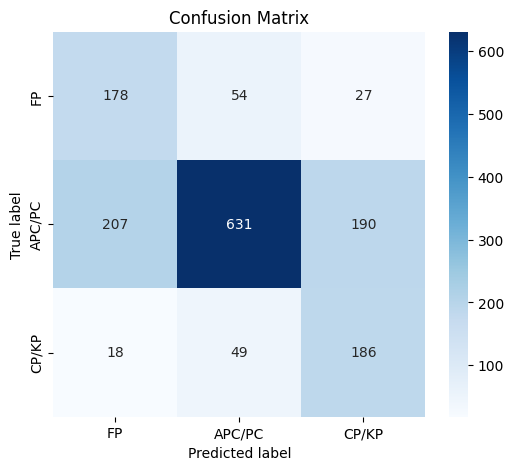

In [70]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FP", "APC/PC", "CP/KP"]  # adjust if you have FA/APC classes

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [75]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 64.61%
